In [213]:
import os
import runpy
import time
from os.path import join as pjoin
import warnings
import glob
import sys
import csv
import pandas as pd
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
from scipy import signal
from scipy.stats import zscore
from nilearn.image import load_img
from nilearn.masking import apply_mask
import matplotlib.pyplot as plt
import re
import warnings
from scipy import stats
import numpy as np
from brainiak.funcalign.rsrm import RSRM
from brainiak.funcalign.srm import SRM
from nilearn.image import load_img
from sklearn.metrics import confusion_matrix
from sklearn.svm import NuSVC
from sklearn import svm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from termcolor import colored
import nibabel as nib
from nilearn import datasets, image
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
%autosave 5

Autosaving every 5 seconds


Autosaving every 5 seconds


In [3]:
def get_digit_indices(n_cycles=20,
                      vols_per_digit=2.56):
    """
    Produce two boolean arrays, one for each run.
    Each array has shape (n_digits, n_volumes).
    Use these to select samples in our classification task
    """
    vols_per_digit_upsampled = int(vols_per_digit * 100)
    digits_run1 = []
    for didx in range(1, 6):
        # create series of 1s for the first finger stimulation
        finger_signal = signal.boxcar(vols_per_digit_upsampled)
        # add zeros before and after accordingly to form first cycle.
        post_padded = np.append(finger_signal, [0] * vols_per_digit_upsampled * (5 - didx))
        first_cycle = np.insert(post_padded, obj=0, values=[0] * vols_per_digit_upsampled * (didx - 1))
        all_cycles = np.tile(first_cycle, n_cycles)  # repeat to get all cycles
        # resample to volume space (i.e. take every 100th element)
        # and turn into boolean vector
        digit_bool = all_cycles[::100] > 0.01
        digits_run1.append(digit_bool)
    digits_run1 = np.array(digits_run1)
    digits_run2 = np.flip(digits_run1, axis=0)
    return digits_run1, digits_run2
def digit_indices_to_labels(digits_run1, digits_run2):
    """
    Turn the boolean arrays of digit indices
    into 1d arrays with values 1-6
    for use with sklearn classifiers.
    """
    labels_run1, labels_run2 = np.zeros(shape=256), np.zeros(shape=256)
    for finger_i in range(1, 6):
        labels_run1[digits_run1[finger_i - 1]] = finger_i
        labels_run2[digits_run2[finger_i - 1]] = finger_i
        
    labels_run1 = labels_run1
    labels_run2 = labels_run2#[:253]
    return labels_run1, labels_run2
digits_run1, digits_run2 = get_digit_indices(n_cycles=20,vols_per_digit=2.56)
labels_run1, labels_run2 = digit_indices_to_labels(digits_run1, digits_run2)


In [4]:
#load labels and subjects
"""importing young """

with open('/Users/akalyani/Desktop/projects/somato_align/scripts/young_subjects.txt') as inf:
    reader = csv.reader(inf, delimiter="\t")
    young = list(zip(*reader))[0]

    
"""importing old """
with open('/Users/akalyani/Desktop/projects/somato_align/scripts/old_subjects.txt') as inf:
    reader = csv.reader(inf, delimiter="\t")
    old = list(zip(*reader))[0]
    
    
old = list(old)
old.pop(4)
young = list(young)
young.pop(2)
age = [young, old]


In [5]:
#Crossval projection then classification
def get_digit_indices(n_cycles=20,
                      vols_per_digit=2.56):
    """
    Produce two boolean arrays, one for each run.
    Each array has shape (n_digits, n_volumes).
    Use these to select samples in our classification task
    """
    vols_per_digit_upsampled = int(vols_per_digit * 100)
    digits_run1 = []
    for didx in range(1, 6):
        # create series of 1s for the first finger stimulation
        finger_signal = signal.boxcar(vols_per_digit_upsampled)
        # add zeros before and after accordingly to form first cycle.
        post_padded = np.append(finger_signal, [0] * vols_per_digit_upsampled * (5 - didx))
        first_cycle = np.insert(post_padded, obj=0, values=[0] * vols_per_digit_upsampled * (didx - 1))
        all_cycles = np.tile(first_cycle, n_cycles)  # repeat to get all cycles
        # resample to volume space (i.e. take every 100th element)
        # and turn into boolean vector
        digit_bool = all_cycles[::100] > 0.01
        digits_run1.append(digit_bool)
    digits_run1 = np.array(digits_run1)
    digits_run2 = np.flip(digits_run1, axis=0)
    return digits_run1, digits_run2
def digit_indices_to_labels(digits_run1, digits_run2):
    """
    Turn the boolean arrays of digit indices
    into 1d arrays with values 1-6
    for use with sklearn classifiers.
    """
    labels_run1, labels_run2 = np.zeros(shape=256), np.zeros(shape=256)
    for finger_i in range(1, 6):
        labels_run1[digits_run1[finger_i - 1]] = finger_i
        labels_run2[digits_run2[finger_i - 1]] = finger_i
        
    labels_run1 = labels_run1
    labels_run2 = labels_run2#[:253]
    return labels_run1, labels_run2
digits_run1, digits_run2 = get_digit_indices(n_cycles=20,vols_per_digit=2.56)
labels_run1, labels_run2 = digit_indices_to_labels(digits_run1, digits_run2)

"""Leave one subject out projection"""
def run_crossval_classification_given_k(arrs1,
                                        arrs2,
                                        k, col,age_idx,region,
                                        niter,):
   

    # prepare empty results array # shape (nlabels, nruns, nsubs)
    nlabels = len(arrs1[1]) # arrs1[1] = first sub array
    nruns = 2
    nsubs =len(arrs1)
    acc_results = np.zeros(shape=(nruns,nsubs))
   
    """iterate over labels"""
    
    run1_arrs = arrs1
    run2_arrs = arrs2
    proj_run_dat=[]
    trained_srms_dat=[]
    for trainrun_idx in range(2):  # iterate over runs
        # select run used for training and test and according digit indices
        training_arrs = (run1_arrs, run2_arrs)[trainrun_idx]
        test_arrs = (run1_arrs, run2_arrs)[abs(trainrun_idx - 1)]
            
        projected_data = list(np.zeros(nsubs))
        trained_srms = list(np.zeros(nsubs))
        # iterate over testsubjects
        for testsub_idx in range(len(training_arrs)):
            start = time.time()
            print('starting run %i subject %i' % (trainrun_idx, testsub_idx))

            trainsubs_traindata = [x for i, x in enumerate(training_arrs) if i != testsub_idx]  # select training data
            testsub_traindata = training_arrs[testsub_idx]

            srm = RSRM(n_iter=niter, features=k)  # train srm on training subject's training data
            srm.fit((trainsubs_traindata))
            w, s = srm.transform_subject((testsub_traindata))  # estimate test subject's bases

            # reattach weight matrix and individual term to srm instance
            # (to allow transforming test run with builtin brainiak function)
            srm.w_.insert(testsub_idx, w)
            srm.s_.insert(testsub_idx, s)

            shared_test, ind_terms = srm.transform(test_arrs)  # project test run into shared space
            testsub_proj = shared_test[testsub_idx]  # select projected data from test subject
            trained_srms[testsub_idx] = srm.r_
            projected_data[testsub_idx] = testsub_proj
            elapsed = time.time() - start
            print('this round took: ', elapsed)

        # save results array for this run
        proj_run_dat.append(projected_data)
        trained_srms_dat.append(trained_srms)

    
    print('done!')
     
    np.savez('/Volumes/AvinashPhD/cSRM/FINAL_RESULTS/COLUMN_projection_THRESH_%s_%s_%s_%s.npz' %(col,age_idx,k,region) ,proj_data = proj_run_dat, srms = trained_srms)

    return None
    

def classify(digit_data_shared , labels,subjects,vox,age_idx,k):    
    #subjects=len(arrs1)
    train_labels = np.tile(labels, subjects-1)
    test_labels = labels
    accuracy = np.zeros((subjects))
    cm = [None] * subjects
   
    for subject in range(subjects):
        digit_data_shared[subject] = np.nan_to_num(stats.zscore(digit_data_shared[subject], axis=1, ddof=1))
    for subject in range(subjects):
        # Concatenate the subjects' data for training into one matrix
        train_subjects = list(range(subjects))
        train_subjects.remove(subject)
        TRs = digit_data_shared[0].shape[1]
        train_data = np.zeros((digit_data_shared[0].shape[0], len(train_labels)))
        for train_subject in range(len(train_subjects)):
            start_index = train_subject*TRs
            end_index = start_index+TRs
            train_data[:, start_index:end_index] = digit_data_shared[train_subjects[train_subject]]

        # Train a Nu-SVM classifier using scikit learn
        classifier = NuSVC(nu=0.5, kernel='rbf', gamma='auto')
        classifier = classifier.fit(train_data.T, train_labels)

        # Predict on the test data
        predicted_labels = classifier.predict(digit_data_shared[subject].T)
        accuracy[subject] = sum(predicted_labels == test_labels)/float(len(predicted_labels))

        # Create a confusion matrix to see the accuracy of each class
        cm[subject] = confusion_matrix(test_labels, predicted_labels)

        # Normalize the confusion matrix
        cm[subject] = cm[subject].astype('float') / cm[subject].sum(axis=1)[:, np.newaxis]
        
        
    return accuracy, cm

In [7]:
#calling all the columnar 
ds_dir = '/Volumes/RG_Kuehn/Avinash/cSRM/sense_data'
n_cols = (list(np.arange(10,100,10)))
area = ['BA1','BA2','BA3b']
reg_run1, reg_run2 =[],[]
for reg_idx, reg_id in enumerate(area):
    cols_run1, cols_run2=[],[]
    for n_col in n_cols:     
        arrs1_1=  []
        arrs1_2=  []
        for age_idx,sub_ids in enumerate(age): 
            run1_a1 , run2_a1 = [],[]
            for sub_idx,sub_id in enumerate(sub_ids):
                sub_dir = pjoin(ds_dir,sub_id)
                path1_1=pjoin(sub_dir, 'columnar_analysis/lh_columns_%s.%s_mean_FINAL.thresh.dat'%(n_col,reg_id))
            
                path1_2=pjoin(sub_dir, 'columnar_analysis/lh_columns_%s.%s_mean_FINAL2.thresh.dat'%(n_col,reg_id))

                run1a_1= np.loadtxt(path1_1, dtype = 'float32')
            
                run1a_2= np.loadtxt(path1_2, dtype = 'float32')
            
                run1_a1.append(run1a_1)
                run2_a1.append(run1a_2)
            arrs1_1.append(run1_a1)
            arrs1_2.append(run2_a1)
        cols_run1.append(arrs1_1)
        cols_run2.append(arrs1_2)
    reg_run1.append(cols_run1)
    reg_run2.append(cols_run2)

In [18]:
feats= [5, 10]

In [ ]:
for region_idx,region in enumerate(area): 
    for col_idx,col in enumerate(n_cols):
        for age_idx, sub_ids in enumerate(age):
            arrs1 = [np.nan_to_num(zscore(reg_run1[region_idx][col_idx][age_idx][i], axis=1, ddof=1)) for i in range(19)]
            arrs2 = [np.nan_to_num(zscore(reg_run2[region_idx][col_idx][age_idx][i], axis=1, ddof=1)) for i in range(19)]
            path = ('/Volumes/AvinashPhD/cSRM/FINAL_RESULTS/COLUMN_projection_THRESH_%s_%s_%s_%s.npz' %(col,age_idx,10,region))
            print("col:",col,"region:", region)
            isExist = os.path.exists(path)
            if isExist :
                [run_crossval_classification_given_k(arrs1,
                                        arrs2,
                                        n_feat,col ,age_idx,region,
                                        30) for n_feat in feats]

In [7]:
#n_cols = (list(np.arange(10,100,10)))
area = ['BA1','BA2','BA3b']
feats= [5, 10]

In [8]:
n_cols = (list(np.arange(10,100,10)))
n_cols2 =(list(np.arange(100,450,50)))
n_cols3 = np.concatenate((n_cols,n_cols2),axis = 0)

In [10]:

for col in n_cols3:
    for age_idx, sub_ids in enumerate(age):
        for region in area:
            for n_feat in feats:
                with np.load('/Volumes/AvinashPhD/cSRM/FINAL_RESULTS/COLUMN_projection_THRESH_%s_%s_%s_%s.npz' %(col,age_idx,n_feat,region), allow_pickle = True) as data:
                    shared_all = data['proj_data']
           
                accu_runs, cm_runs = [],[]
                for run_idx in range(2):  # iterate over runs
                    # select run used for training and test and according digit indices
                    digit_data_shared = shared_all[run_idx]
                    labels = (labels_run1, labels_run2)[run_idx]
                    subjects , feat, TRs = digit_data_shared.shape
                    accu, cm = classify(digit_data_shared,labels, subjects,col,age_idx,10)
                
                    accu_runs.append(accu)
                    cm_runs.append(cm)
            
                print(np.mean(accu),'cols:',col,'age:', age_idx, 'region:',region)   
                np.savez('/Volumes/AvinashPhD/cSRM/FINAL_RESULTS/COLUMN_classification_THRESH_%s_%s_%s_%s.npz' %(col,age_idx,n_feat,region) ,accuracy = accu_runs, cm = cm_runs)

0.39453125 cols: 10 age: 0 region: BA1
0.3696546052631579 cols: 10 age: 0 region: BA1
0.30694901315789475 cols: 10 age: 0 region: BA2
0.2915296052631579 cols: 10 age: 0 region: BA2
0.32134046052631576 cols: 10 age: 0 region: BA3b
0.3365542763157895 cols: 10 age: 0 region: BA3b
0.28597861842105265 cols: 10 age: 1 region: BA1
0.3071546052631579 cols: 10 age: 1 region: BA1
0.2730263157894737 cols: 10 age: 1 region: BA2
0.2514391447368421 cols: 10 age: 1 region: BA2
0.2954358552631579 cols: 10 age: 1 region: BA3b
0.33120888157894735 cols: 10 age: 1 region: BA3b
0.3978207236842105 cols: 20 age: 0 region: BA1
0.4263980263157895 cols: 20 age: 0 region: BA1
0.3441611842105263 cols: 20 age: 0 region: BA2
0.2722039473684211 cols: 20 age: 0 region: BA2
0.32319078947368424 cols: 20 age: 0 region: BA3b
0.3386101973684211 cols: 20 age: 0 region: BA3b
0.2917351973684211 cols: 20 age: 1 region: BA1
0.37027138157894735 cols: 20 age: 1 region: BA1
0.2709703947368421 cols: 20 age: 1 region: BA2
0.3003700

KeyboardInterrupt: 

In [10]:
accuracies = np.zeros(shape=(len(n_cols3), 2, 3 , len(feats)))
stdv = np.zeros(shape=(len(n_cols3), 2, 3 , len(feats)))
for col_idx, col in enumerate(n_cols3):
    for age_idx, sub_ids in enumerate(age):
        for region_idx, region in enumerate(area):
            for feat_idx, feat in enumerate(feats):
                with np.load('/Volumes/AvinashPhD/cSRM/FINAL_RESULTS/COLUMN_classification_THRESH_%s_%s_%s_%s.npz' %(col,age_idx,feat,region), allow_pickle = True) as data:
                    accuracy = data['accuracy']
                
                accuracies[col_idx, age_idx, region_idx,feat_idx] = np.mean(accuracy)
                stdv[col_idx, age_idx, region_idx,feat_idx] = np.std(accuracy)

In [23]:
accuracies_all = [] #np.zeros(shape=(len(n_cols3), 2, 3 , len(feats)))
#stdv = [] #np.zeros(shape=(len(n_cols3), 2, 3 , len(feats)))
for col_idx, col in enumerate(n_cols3):
    accu_age = []
    for age_idx, sub_ids in enumerate(age):
        accu_region = []
        for region_idx, region in enumerate(area):
            accu_feat = []
            for feat_idx, feat in enumerate(feats):
                with np.load('/Volumes/AvinashPhD/cSRM/FINAL_RESULTS/COLUMN_classification_THRESH_%s_%s_%s_%s.npz' %(col,age_idx,feat,region), allow_pickle = True) as data:
                    accuracy = data['accuracy']
                accu = [*accuracy[0], *accuracy[1]]
                accu_feat.append(accu)
            accu_region.append(accu_feat)
        accu_age.append(accu_region)
        
    accuracies_all.append(accu_age)

In [18]:
accuracies_all = [] #np.zeros(shape=(len(n_cols3), 2, 3 , len(feats)))
#stdv = [] #np.zeros(shape=(len(n_cols3), 2, 3 , len(feats)))
for col_idx, col in enumerate(n_cols3):
    accu_age = []
    for age_idx, sub_ids in enumerate(age):
        accu_region = []
        for region_idx, region in enumerate(area):
            accu_feat = []
            for feat_idx, feat in enumerate(feats):
                with np.load('/Volumes/AvinashPhD/cSRM/FINAL_RESULTS/COLUMN_classification_THRESH_%s_%s_%s_%s.npz' %(col,age_idx,feat,region), allow_pickle = True) as data:
                    accuracy = data['accuracy']
                accu = np.mean(accuracy, axis = 0)
                accu_feat.append(accu)
            accu_region.append(accu_feat)
        accu_age.append(accu_region)
        
    accuracies_all.append(accu_age)

In [19]:
len(np.mean(accuracy, axis = 0))

19

In [64]:
#find the maximum column number for each subject
sub_col_accu_y = np.zeros(shape=(3,19,16))
sub_col_accu_o = np.zeros(shape=(3,19,16))
for m in range(3):
    for j in range(19):    
        for i in range(len(n_cols3)):
            sub_col_accu_y[m,j,i] = accuracies_all[i][0][m][1][j]
            sub_col_accu_o[m,j,i] = accuracies_all[i][1][m][1][j]

In [66]:
sub_col_y = np.zeros(shape=(3,19))
sub_col_o = np.zeros(shape=(3,19))
for m in range(3):
    for k in range(19):    
        sub_col_y[m,k] = n_cols3[np.argmax(sub_col_accu_y[m][k], axis = 0)]
        sub_col_o[m,k] = n_cols3[np.argmax(sub_col_accu_o[m][k], axis = 0)]

In [90]:
df_y_col = pd.DataFrame(sub_col_y.T, columns = ['BA1','BA2','BA3b'])
df_y_col['sub'] = list(range(len(df_y_col.index)))
df_y_col['age'] = 'young'
df_o_col = pd.DataFrame(sub_col_o.T, columns = ['BA1','BA2','BA3b'])
df_o_col['sub'] = list(range(len(df_o_col.index)))
df_o_col['age'] = 'old'

In [163]:
df_col_y2 =pd.melt(df_y_col, id_vars=['sub','BA1','BA2','BA3b'], value_vars=['age'])
df_col_o2 =pd.melt(df_o_col, id_vars=['sub','BA1','BA2','BA3b'], value_vars=['age'])

In [164]:
df2 = df_col_y2.append(df_col_o2)

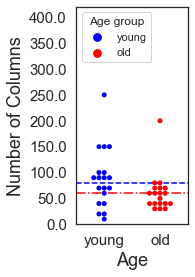

In [347]:
sns.set_style("white")
p=sns.swarmplot(x="value", y="BA1",hue = 'value', data=df2,palette=['blue','red'])
plt.legend(title='Age group', loc='upper left')
p.set_xlabel("Age", fontsize = 18)
p.set_ylabel("Number of Columns", fontsize = 18)
p.axhline(80, color = 'blue',linestyle = '--')
p.axhline(60, color = 'red',linestyle = '-.')
p.set_ylim([0,420])
p.set_yticklabels(p.get_yticks(), size = 15)
p.set_xticklabels(['young','old'], size = 15)
sns.set(rc={'figure.figsize':(2,4)})
#sns.despine()
plt.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_BA1_curve_max_SUB.png', dpi=300, bbox_inches = "tight")

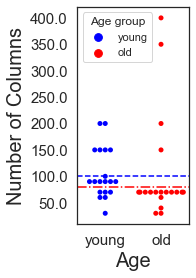

In [348]:
sns.set_style("white")
p=sns.swarmplot(x="value", y="BA2",hue = 'value', data=df2,palette=['blue','red'])
plt.legend(title='Age group', loc='upper left')
p.set_xlabel("Age", fontsize = 20)
p.set_ylabel("Number of Columns", fontsize = 20)
p.axhline(100, color = 'blue',linestyle = '--')
p.axhline(80, color = 'red',linestyle = '-.')
p.set_yticklabels(p.get_yticks(), size = 15)
p.set_xticklabels(['young','old'], size = 15)
sns.set(rc={'figure.figsize':(2,4)})
plt.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_BA2_curve_max_SUB.png', dpi=300, bbox_inches = "tight")

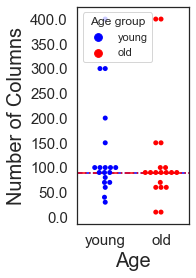

In [349]:
sns.set_style("white")
p=sns.swarmplot(x="value", y="BA3b",hue = 'value', data=df2,palette=['blue','red'])
plt.legend(title='Age group', loc='upper left')
p.set_xlabel("Age", fontsize = 20)
p.set_ylabel("Number of Columns", fontsize = 20)
p.set_yticklabels(p.get_yticks(), size = 15)
p.set_xticklabels(['young','old'], size = 15)
p.axhline(90, color = 'blue',linestyle = '--')
p.axhline(90, color = 'red', linestyle = '-.')
sns.set(rc={'figure.figsize':(2,4)})
plt.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_BA3b_curve_max_SUB.png', dpi=300, bbox_inches = "tight")

In [24]:
stdv_BA1_Y_F5 =np.asarray([(stdv[i,0,0,0]) for i in range(len(n_cols3))])
accu_BA1_Y_F5 = np.asarray([(accuracies[i,0,0,0]) for i in range(len(n_cols3))])
stdv_BA1_O_F5 =np.asarray([(stdv[i,1,0,0]) for i in range(len(n_cols3))])
accu_BA1_O_F5 = np.asarray([(accuracies[i,1,0,0]) for i in range(len(n_cols3))])

In [25]:
stdv_BA2_Y_F5 =np.asarray([(stdv[i,0,1,0]) for i in range(len(n_cols3))])
accu_BA2_Y_F5 = np.asarray([(accuracies[i,0,1,0]) for i in range(len(n_cols3))])
stdv_BA2_O_F5 =np.asarray([(stdv[i,1,1,0]) for i in range(len(n_cols3))])
accu_BA2_O_F5 = np.asarray([(accuracies[i,1,1,0]) for i in range(len(n_cols3))])

In [26]:
stdv_BA3b_Y_F5 =np.asarray([(stdv[i,0,2,0]) for i in range(len(n_cols3))])
accu_BA3b_Y_F5 = np.asarray([(accuracies[i,0,2,0]) for i in range(len(n_cols3))])
stdv_BA3b_O_F5 =np.asarray([(stdv[i,1,2,0]) for i in range(len(n_cols3))])
accu_BA3b_O_F5 = np.asarray([(accuracies[i,1,2,0]) for i in range(len(n_cols3))])

In [27]:
stdv_BA1_Y_F10 =np.asarray([(stdv[i,0,0,1]) for i in range(len(n_cols3))])
accu_BA1_Y_F10 = np.asarray([(accuracies[i,0,0,1]) for i in range(len(n_cols3))])
stdv_BA1_O_F10 =np.asarray([(stdv[i,1,0,1]) for i in range(len(n_cols3))])
accu_BA1_O_F10 = np.asarray([(accuracies[i,1,0,1]) for i in range(len(n_cols3))])

In [28]:
stdv_BA2_Y_F10 =np.asarray([(stdv[i,0,1,1]) for i in range(len(n_cols3))])
accu_BA2_Y_F10 =np.asarray( [(accuracies[i,0,1,1]) for i in range(len(n_cols3))])
stdv_BA2_O_F10 =np.asarray([(stdv[i,1,1,1]) for i in range(len(n_cols3))])
accu_BA2_O_F10 = np.asarray([(accuracies[i,1,1,1]) for i in range(len(n_cols3))])

In [29]:
stdv_BA3b_Y_F10 =np.asarray([(stdv[i,0,2,1]) for i in range(len(n_cols3))])
accu_BA3b_Y_F10 = np.asarray([(accuracies[i,0,2,1]) for i in range(len(n_cols3))])
stdv_BA3b_O_F10 =np.asarray([(stdv[i,1,2,1]) for i in range(len(n_cols3))])
accu_BA3b_O_F10 = np.asarray([(accuracies[i,1,2,1]) for i in range(len(n_cols3))])

accuracies_all[col][age][region][feat]

In [35]:
from tsmoothie.smoother import *
def col_smooth_plot(stdv, accuracies, area_idx,feat_idx, n_cols ):
    stdv_BA1_Y_F10 =[(stdv[i,0,area_idx,feat_idx]) for i in range(len(n_cols))]
    accu_BA1_Y_F10 = [(accuracies[i,0,area_idx,feat_idx]) for i in range(len(n_cols))]
    stdv_BA1_O_F10 =[(stdv[i,1,area_idx,feat_idx]) for i in range(len(n_cols))]
    accu_BA1_O_F10 = [(accuracies[i,1,area_idx,feat_idx]) for i in range(len(n_cols))]
    x = np.linspace(0,2*np.pi,100)
    y = accu_BA1_Y_F10
    y_1 = (np.asarray(accu_BA1_Y_F10) - np.asarray(stdv_BA1_Y_F10))
    y_2 = (np.asarray(accu_BA1_Y_F10) + np.asarray(stdv_BA1_Y_F10))
    y2 = accu_BA1_O_F10
    y2_1 = (np.asarray(accu_BA1_O_F10) - np.asarray(stdv_BA1_O_F10))
    y2_2 = (np.asarray(accu_BA1_O_F10) + np.asarray(stdv_BA1_O_F10))
    
    #maxima
    max_val_y = np.argmax(y, axis = 0)
    max_val_o = np.argmax(y2, axis = 0)
    
    # operate smoothing

    smoother = GaussianSmoother(n_knots=6, sigma=0.1)
    smoother.smooth(y)
    smoother2 = GaussianSmoother(n_knots=6, sigma=0.1)
    smoother2.smooth(y2)
    smoother_1 = GaussianSmoother(n_knots=6, sigma=0.1)
    smoother_1.smooth(y_1)
    smoother_2 = GaussianSmoother(n_knots=6, sigma=0.1)
    smoother_2.smooth(y_2)
    smoother2_1 = GaussianSmoother(n_knots=6, sigma=0.1)
    smoother2_1.smooth(y2_1)
    smoother2_2 = GaussianSmoother(n_knots=6, sigma=0.1)
    smoother2_2.smooth(y2_2)




    # generate intervals
    low, up = smoother.get_intervals('sigma_interval', n_sigma=3)
    low2, up2 = smoother2.get_intervals('sigma_interval', n_sigma=3)
    low_1, up_1 = smoother_1.get_intervals('sigma_interval', n_sigma=3)
    low_2, up_2 = smoother_2.get_intervals('sigma_interval', n_sigma=3)
    low2_1, up2_1 = smoother2_1.get_intervals('sigma_interval', n_sigma=3)
    low2_2, up2_2 = smoother2_2.get_intervals('sigma_interval', n_sigma=3)
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=(8, 4))
    # plot the smoothed timeseries with intervals
    #.figure(figsize=(11,6))
    ax.plot(smoother.smooth_data[0], linewidth=3, color='blue', label = "Young_K10")
    ax.plot(smoother.data[0], '.b')
    ax.plot(smoother2.smooth_data[0], linewidth=3, color='red', label = "Old_K10")
    ax.plot(smoother2.data[0], '.r')
    max_val_y2 = np.argmax(smoother.smooth_data[0], axis = 0)
    max_val_o2 = np.argmax(smoother2.smooth_data[0], axis = 0)
    #ax.plot(smoother_1.data[0], '.b')
    #ax.plot(smoother_2.data[0], '.b')
    #ax.plot(smoother2_1.data[0], '.r')
    #ax.plot(smoother2_2.data[0], '.r')


    ax.fill_between(range(len(smoother.data[0])), low_1[0],up_2[0] ,color = 'blue', alpha=0.2)

    ax.fill_between(range(len(smoother2.data[0])), low2_1[0],up2_2[0],color = 'red', alpha=0.2)
    plt.title(area[area_idx], fontsize = 20)
    ax.set_ylim([0,0.8])
    x= list(range(len(n_cols)))
    ax.set_xticks(x)
    col_label = n_cols.astype('str')
    ax.set_xticklabels(col_label)
    ax.set_ylabel("Accuracy", fontsize = 18)
    ax.set_xlabel("N_Columns", fontsize = 18)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=14)
    
    plt.axvline(max_val_y2, color = 'blue', linestyle = '-.', label = 'Young curve peak')
    plt.axvline(max_val_o2, color = 'red', linestyle = '--',label = 'Old curve peak')
    ax.legend(loc='best', fontsize =13)
    #plt.axvline(max_val_y, color = 'blue', linestyle = 'dashdot')
    #plt.axvline(max_val_o, color = 'red', linestyle = 'dashdot')
    plt.show()
    fig.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_BA%s_curve_max.png'%area_idx, dpi=300, bbox_inches = "tight")
    return None

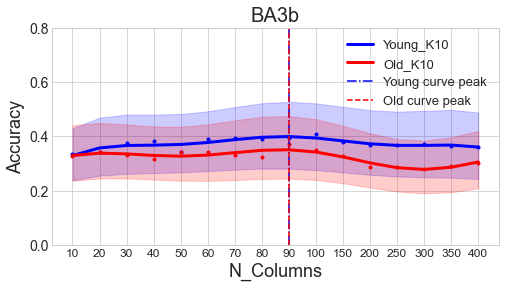

In [36]:
col_smooth_plot(stdv, accuracies,2,1, n_cols3 )

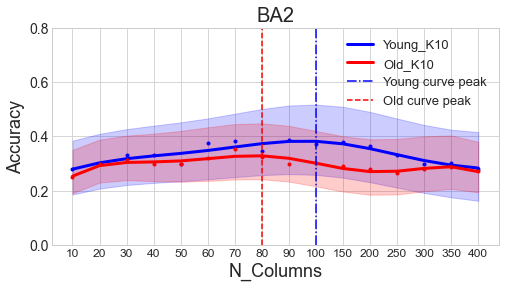

In [37]:
col_smooth_plot(stdv, accuracies,1,1, n_cols3 )


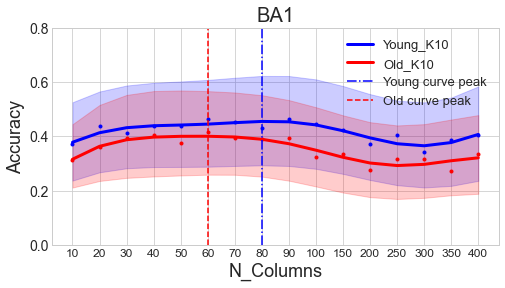

In [38]:
col_smooth_plot(stdv, accuracies,0,1, n_cols3 )

In [40]:
col_label = n_cols3.astype('str')

Text(0.5, 1.0, 'BA1')

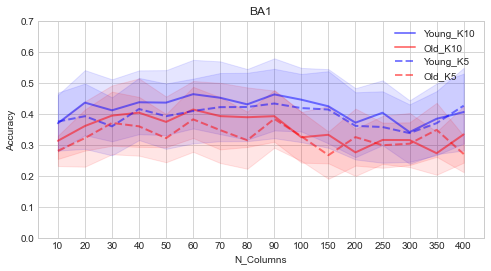

In [42]:
plt.style.use('seaborn-whitegrid') #Change/Remove This If you Want
accu_BA1_Y_F10 = np.asarray(accu_BA1_Y_F10)
stdv_BA1_Y_F10 = np.asarray(stdv_BA1_Y_F10)
accu_BA1_O_F10 = np.asarray(accu_BA1_O_F10)
stdv_BA1_O_F10 = np.asarray(stdv_BA1_O_F10)
accu_BA1_Y_F5 = np.asarray(accu_BA1_Y_F5)
stdv_BA1_Y_F5 = np.asarray(stdv_BA1_Y_F5)
accu_BA1_O_F5 = np.asarray(accu_BA1_O_F5)
stdv_BA1_O_F5 = np.asarray(stdv_BA1_O_F5)
fig, ax = plt.subplots(figsize=(8, 4))
x= list(range(len(n_cols3)))
ax.plot(x, accu_BA1_Y_F10, alpha=0.5, color='blue', label='Young_K10', linewidth = 2.0)
ax.plot(x, accu_BA1_O_F10, alpha=0.5, color='red', label='Old_K10', linewidth = 2.0)
ax.fill_between(x, accu_BA1_Y_F10 - stdv_BA1_Y_F10, accu_BA1_Y_F10 + stdv_BA1_Y_F10, color='b', alpha=0.1)
ax.fill_between(x, accu_BA1_O_F10 - stdv_BA1_O_F10, accu_BA1_O_F10 + stdv_BA1_O_F10, color='r', alpha=0.1)
ax.plot(x, accu_BA1_Y_F5, alpha=0.5, color='blue',ls = '--', label='Young_K5', linewidth = 2.0)
ax.plot(x, accu_BA1_O_F5, alpha=0.5, color='red',ls = '--', label='Old_K5', linewidth = 2.0)
ax.fill_between(x, accu_BA1_Y_F5 - stdv_BA1_Y_F5, accu_BA1_Y_F5 + stdv_BA1_Y_F5, color='b', alpha=0.1)
ax.fill_between(x, accu_BA1_O_F5 - stdv_BA1_O_F5, accu_BA1_O_F5 + stdv_BA1_O_F5, color='r', alpha=0.1)
ax.legend(loc='best')
ax.set_ylim([0,0.7])
ax.set_xticks(x)
ax.set_xticklabels(col_label)
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_Columns")
plt.title("BA1")
#fig.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_BA1.png', dpi=300)

In [ ]:
plt.style.use('seaborn-whitegrid') #Change/Remove This If you Want
fig, ax = plt.subplots(figsize=(8, 4))
x= list(range(len(n_cols3)))
ax.plot(x, accu_BA2_Y_F10, alpha=0.5, color='blue', label='Young_K10', linewidth = 2.0)
ax.plot(x, accu_BA2_O_F10, alpha=0.5, color='red', label='Old_K10', linewidth = 2.0)
ax.fill_between(x, accu_BA2_Y_F10 - stdv_BA2_Y_F10, accu_BA2_Y_F10 + stdv_BA2_Y_F10, color='b', alpha=0.1)
ax.fill_between(x, accu_BA2_O_F10 - stdv_BA2_O_F10, accu_BA2_O_F10 + stdv_BA2_O_F10, color='r', alpha=0.1)
ax.plot(x, accu_BA2_Y_F5, alpha=0.5, color='blue',ls = '--', label='Young_K5', linewidth = 2.0)
ax.plot(x, accu_BA2_O_F5, alpha=0.5, color='red',ls = '--', label='Old_K5', linewidth = 2.0)
ax.fill_between(x, accu_BA2_Y_F5 - stdv_BA2_Y_F5, accu_BA2_Y_F5 + stdv_BA2_Y_F5, color='b', alpha=0.1)
ax.fill_between(x, accu_BA2_O_F5 - stdv_BA2_O_F5, accu_BA2_O_F5 + stdv_BA2_O_F5, color='r', alpha=0.1)
ax.legend(loc='best')
ax.set_ylim([0,0.7])
ax.set_xticks(x)
ax.set_xticklabels(col_label)
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_Columns")
plt.title("BA2")
fig.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_BA2.png', dpi=300)

In [ ]:
plt.style.use('seaborn-whitegrid') #Change/Remove This If you Want
fig, ax = plt.subplots(figsize=(8, 4))
x= list(range(len(n_cols3)))
ax.plot(x, accu_BA3b_Y_F10, alpha=0.5, color='blue', label='Young_K10', linewidth = 2.0)
ax.plot(x, accu_BA3b_O_F10, alpha=0.5, color='red', label='Old_K10', linewidth = 2.0)
ax.fill_between(x, accu_BA3b_Y_F10 - stdv_BA3b_Y_F10, accu_BA3b_Y_F10 + stdv_BA3b_Y_F10, color='b', alpha=0.1)
ax.fill_between(x, accu_BA3b_O_F10 - stdv_BA3b_O_F10, accu_BA3b_O_F10 + stdv_BA3b_O_F10, color='r', alpha=0.1)
ax.plot(x, accu_BA3b_Y_F5, alpha=0.5, color='blue',ls = '--', label='Young_K5', linewidth = 2.0)
ax.plot(x, accu_BA3b_O_F5, alpha=0.5, color='red',ls = '--', label='Old_K5', linewidth = 2.0)
ax.fill_between(x, accu_BA3b_Y_F5 - stdv_BA3b_Y_F5, accu_BA3b_Y_F5 + stdv_BA3b_Y_F5, color='b', alpha=0.1)
ax.fill_between(x, accu_BA3b_O_F5 - stdv_BA3b_O_F5, accu_BA3b_O_F5 + stdv_BA3b_O_F5, color='r', alpha=0.1)
ax.legend(loc='best')
ax.set_ylim([0,0.7])
ax.set_xticks(x)
ax.set_xticklabels(col_label)
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_Columns")
plt.title("BA3b")
fig.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_BA3b.png', dpi=300)

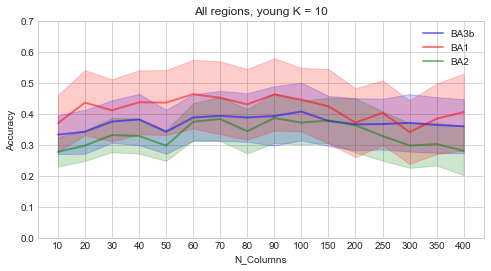

In [101]:
plt.style.use('seaborn-whitegrid') #Change/Remove This If you Want
fig, ax = plt.subplots(figsize=(8, 4))
x= list(range(len(n_cols3)))
ax.plot(x, accu_BA3b_Y_F10, alpha=0.5, color='blue', label='BA3b', linewidth = 2.0)
ax.plot(x, accu_BA1_Y_F10, alpha=0.5, color='red', label='BA1', linewidth = 2.0)
ax.plot(x, accu_BA2_Y_F10, alpha=0.5, color='green', label='BA2', linewidth = 2.0)
ax.fill_between(x, accu_BA3b_Y_F10 - stdv_BA3b_Y_F10, accu_BA3b_Y_F10 + stdv_BA3b_Y_F10, color='b', alpha=0.2)
ax.fill_between(x, accu_BA2_Y_F10 - stdv_BA2_Y_F10, accu_BA2_Y_F10 + stdv_BA2_Y_F10, color='g', alpha=0.2)
ax.fill_between(x, accu_BA1_Y_F10 - stdv_BA1_Y_F10, accu_BA1_Y_F10 + stdv_BA1_Y_F10, color='r', alpha=0.2)

ax.legend(loc='best')
ax.set_ylim([0,0.7])
ax.set_xticks(x)
ax.set_xticklabels(col_label)
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_Columns")
plt.title("All regions, young K = 10")
fig.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/col_vs_allBAs_y.png', dpi=300)

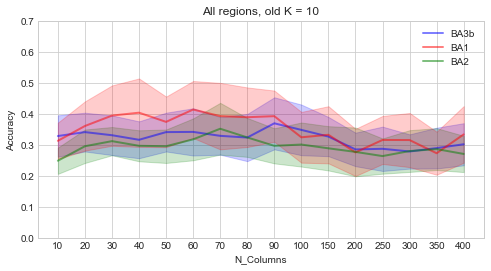

In [102]:
plt.style.use('seaborn-whitegrid') #Change/Remove This If you Want
fig, ax = plt.subplots(figsize=(8, 4))
x= list(range(len(n_cols3)))
ax.plot(x, accu_BA3b_O_F10, alpha=0.5, color='blue', label='BA3b', linewidth = 2.0)
ax.plot(x, accu_BA1_O_F10, alpha=0.5, color='red', label='BA1', linewidth = 2.0)
ax.plot(x, accu_BA2_O_F10, alpha=0.5, color='green', label='BA2', linewidth = 2.0)
ax.fill_between(x, accu_BA3b_O_F10 - stdv_BA3b_O_F10, accu_BA3b_O_F10 + stdv_BA3b_O_F10, color='b', alpha=0.2)
ax.fill_between(x, accu_BA2_O_F10 - stdv_BA2_O_F10, accu_BA2_O_F10 + stdv_BA2_O_F10, color='g', alpha=0.2)
ax.fill_between(x, accu_BA1_O_F10 - stdv_BA1_O_F10, accu_BA1_O_F10 + stdv_BA1_O_F10, color='r', alpha=0.2)

ax.legend(loc='best')
ax.set_ylim([0,0.7])
ax.set_xticks(x)
ax.set_xticklabels(col_label)
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_Columns")
plt.title("All regions, old K = 10")
fig.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/col_vs_allBAs_o.png', dpi=300)

In [64]:
stdv_BA1_o_F10 =[(stdv[i,1,1,0]) for i in range(len(n_cols3))]
accu_BA1_o_F10 = [(accuracies[i,1,1,0]) for i in range(len(n_cols3))]

In [65]:
stdv_BA1_Y_F10 =[(stdv[i,0,1,0]) for i in range(len(n_cols3))]
accu_BA1_Y_F10 = [(accuracies[i,0,1,0]) for i in range(len(n_cols3))]

In [13]:
stdv_BA1_Y_F10 =[(stdv[i,0,0,feat_idx]) for i in range(len(n_cols))]
accu_BA1_Y_F10 = [(accuracies[i,0,0,feat_idx]) for i in range(len(n_cols))]
stdv_BA2_y_F10 =[(stdv[i,0,1,feat_idx]) for i in range(len(n_cols))]
accu_BA2_y_F10 = [(accuracies[i,0,1,feat_idx]) for i in range(len(n_cols))]
stdv_BA3b_y_F10 =[(stdv[i,0,2,feat_idx]) for i in range(len(n_cols))]
accu_BA3b_y_F10 = [(accuracies[i,0,2,feat_idx]) for i in range(len(n_cols))]

In [14]:
stdv_BA1_o_F10 =[(stdv[i,1,0,feat_idx]) for i in range(len(n_cols))]
accu_BA1_o_F10 = [(accuracies[i,1,0,feat_idx]) for i in range(len(n_cols))]
stdv_BA2_o_F10 =[(stdv[i,1,1,feat_idx]) for i in range(len(n_cols))]
accu_BA2_o_F10 = [(accuracies[i,1,1,feat_idx]) for i in range(len(n_cols))]
stdv_BA3b_o_F10 =[(stdv[i,1,2,feat_idx]) for i in range(len(n_cols3))]
accu_BA3b_o_F10 = [(accuracies[i,1,2,feat_idx]) for i in range(len(n_cols3))]

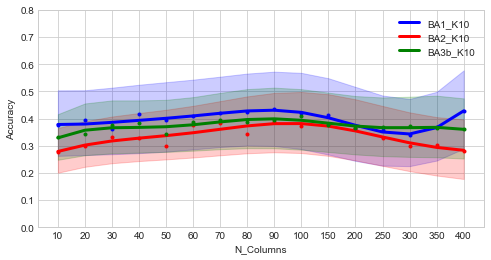

In [82]:
col_smooth_plot_all(stdv, accuracies,0, n_cols3,0 )

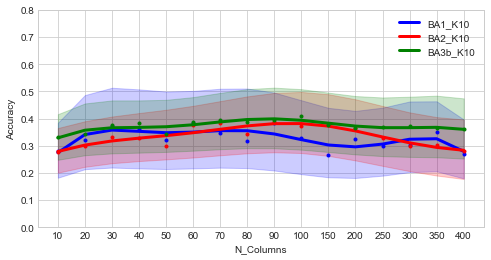

In [83]:
col_smooth_plot_all(stdv, accuracies,0, n_cols3,1)

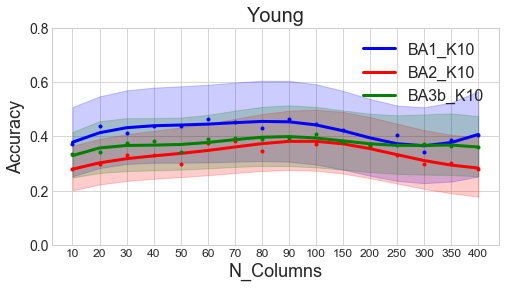

In [57]:
age_idx = 0
feat_idx = 1
n_cols = n_cols3
stdv_BA1_Y_F10 =[(stdv[i,age_idx,0,feat_idx]) for i in range(len(n_cols))]
accu_BA1_Y_F10 = [(accuracies[i,age_idx,0,feat_idx]) for i in range(len(n_cols))]
stdv_BA2_y_F10 =[(stdv[i,age_idx,1,feat_idx]) for i in range(len(n_cols))]
accu_BA2_y_F10 = [(accuracies[i,age_idx,1,feat_idx]) for i in range(len(n_cols))]
stdv_BA3b_y_F10 =[(stdv[i,age_idx,2,feat_idx]) for i in range(len(n_cols))]
accu_BA3b_y_F10 = [(accuracies[i,age_idx,2,feat_idx]) for i in range(len(n_cols))]
x = np.linspace(0,2*np.pi,100)
y = accu_BA1_Y_F10
y_1 = (np.asarray(accu_BA1_Y_F10) - np.asarray(stdv_BA1_Y_F10))
y_2 = (np.asarray(accu_BA1_Y_F10) + np.asarray(stdv_BA1_Y_F10))
y2 = accu_BA2_Y_F10
y2_1 = (np.asarray(accu_BA2_Y_F10) - np.asarray(stdv_BA2_Y_F10))
y2_2 = (np.asarray(accu_BA2_Y_F10) + np.asarray(stdv_BA2_Y_F10))
y3 = accu_BA3b_Y_F10
y3_1 = (np.asarray(accu_BA3b_Y_F10) - np.asarray(stdv_BA3b_Y_F10))
y3_2 = (np.asarray(accu_BA3b_Y_F10) + np.asarray(stdv_BA3b_Y_F10))

smoother = GaussianSmoother(n_knots=6, sigma=0.1)
smoother.smooth(y)
smoother2 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother2.smooth(y2)
smoother_1 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother_1.smooth(y_1)
smoother_2 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother_2.smooth(y_2)
smoother2_1 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother2_1.smooth(y2_1)
smoother2_2 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother2_2.smooth(y2_2)
    
smoother3 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother3.smooth(y3)
smoother3_1 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother3_1.smooth(y3_1)
smoother3_2 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother3_2.smooth(y3_2)




# generate intervals
low, up = smoother.get_intervals('sigma_interval', n_sigma=2)
low2, up2 = smoother2.get_intervals('sigma_interval', n_sigma=2)
low_1, up_1 = smoother_1.get_intervals('sigma_interval', n_sigma=2)
low_2, up_2 = smoother_2.get_intervals('sigma_interval', n_sigma=2)
low2_1, up2_1 = smoother2_1.get_intervals('sigma_interval', n_sigma=2)
low2_2, up2_2 = smoother2_2.get_intervals('sigma_interval', n_sigma=2)
low3_1, up3_1 = smoother3_1.get_intervals('sigma_interval', n_sigma=2)
low3_2, up3_2 = smoother3_2.get_intervals('sigma_interval', n_sigma=2)
    
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(8, 4))
# plot the smoothed timeseries with intervals
#.figure(figsize=(11,6))
ax.plot(smoother.smooth_data[0], linewidth=3, color='blue', label = "BA1_K10")
ax.plot(smoother.data[0], '.b')
ax.plot(smoother2.smooth_data[0], linewidth=3, color='red', label = "BA2_K10")
ax.plot(smoother2.data[0], '.r')
ax.plot(smoother3.smooth_data[0], linewidth=3, color='green', label = "BA3b_K10")
ax.plot(smoother3.data[0], '.g')


#ax.plot(smoother_1.data[0], '.b')
#ax.plot(smoother_2.data[0], '.b')
#ax.plot(smoother2_1.data[0], '.r')
#ax.plot(smoother2_2.data[0], '.r')


ax.fill_between(range(len(smoother.data[0])), low_1[0],up_2[0] ,color = 'blue', alpha=0.2)
ax.fill_between(range(len(smoother2.data[0])), low2_1[0],up2_2[0],color = 'red', alpha=0.2)
#ax.fill_between(range(len(smoother.data[0])), low_1[0],up_2[0] ,color = 'blue', alpha=0.2)
ax.fill_between(range(len(smoother3.data[0])), low3_1[0],up3_2[0],color = 'green', alpha=0.2)
    
    
#plt.title(area[area_idx])
ax.set_ylim([0,0.8])
x= list(range(len(n_cols3)))
ax.set_xticks(x)
col_label = n_cols3.astype('str')
ax.set_xticklabels(col_label,fontsize = 12)
ax.set_ylabel("Accuracy", fontsize = 18)
ax.set_xlabel("N_Columns",fontsize = 18)
ax.legend(loc='best',fontsize = 16)
plt.title("Young",fontsize = 20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
plt.show()
fig.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_across_smooth_age_0.png', dpi=300)

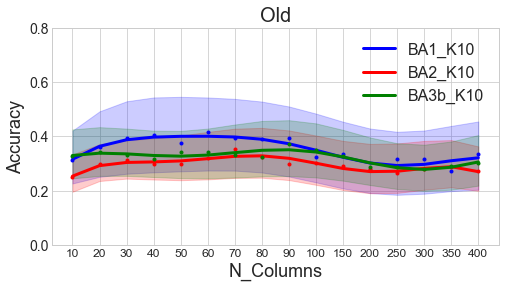

In [46]:
age_idx = 1
feat_idx = 1
n_cols = n_cols3
x = np.linspace(0,2*np.pi,100)
y = accu_BA1_O_F10
y_1 = (np.asarray(accu_BA1_O_F10) - np.asarray(stdv_BA1_O_F10))
y_2 = (np.asarray(accu_BA1_O_F10) + np.asarray(stdv_BA1_O_F10))
y2 = accu_BA2_O_F10
y2_1 = (np.asarray(accu_BA2_O_F10) - np.asarray(stdv_BA2_O_F10))
y2_2 = (np.asarray(accu_BA2_O_F10) + np.asarray(stdv_BA2_O_F10))
y3 = accu_BA3b_O_F10
y3_1 = (np.asarray(accu_BA3b_O_F10) - np.asarray(stdv_BA3b_O_F10))
y3_2 = (np.asarray(accu_BA3b_O_F10) + np.asarray(stdv_BA3b_O_F10))

smoother = GaussianSmoother(n_knots=6, sigma=0.1)
smoother.smooth(y)
smoother2 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother2.smooth(y2)
smoother_1 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother_1.smooth(y_1)
smoother_2 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother_2.smooth(y_2)
smoother2_1 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother2_1.smooth(y2_1)
smoother2_2 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother2_2.smooth(y2_2)
    
smoother3 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother3.smooth(y3)
smoother3_1 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother3_1.smooth(y3_1)
smoother3_2 = GaussianSmoother(n_knots=6, sigma=0.1)
smoother3_2.smooth(y3_2)




# generate intervals
low, up = smoother.get_intervals('sigma_interval', n_sigma=2)
low2, up2 = smoother2.get_intervals('sigma_interval', n_sigma=2)
low_1, up_1 = smoother_1.get_intervals('sigma_interval', n_sigma=2)
low_2, up_2 = smoother_2.get_intervals('sigma_interval', n_sigma=2)
low2_1, up2_1 = smoother2_1.get_intervals('sigma_interval', n_sigma=2)
low2_2, up2_2 = smoother2_2.get_intervals('sigma_interval', n_sigma=2)
low3_1, up3_1 = smoother3_1.get_intervals('sigma_interval', n_sigma=2)
low3_2, up3_2 = smoother3_2.get_intervals('sigma_interval', n_sigma=2)
    
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(8, 4))
# plot the smoothed timeseries with intervals
#.figure(figsize=(11,6))
ax.plot(smoother.smooth_data[0], linewidth=3, color='blue', label = "BA1_K10")
ax.plot(smoother.data[0], '.b')
ax.plot(smoother2.smooth_data[0], linewidth=3, color='red', label = "BA2_K10")
ax.plot(smoother2.data[0], '.r')
ax.plot(smoother3.smooth_data[0], linewidth=3, color='green', label = "BA3b_K10")
ax.plot(smoother3.data[0], '.g')


#ax.plot(smoother_1.data[0], '.b')
#ax.plot(smoother_2.data[0], '.b')
#ax.plot(smoother2_1.data[0], '.r')
#ax.plot(smoother2_2.data[0], '.r')


ax.fill_between(range(len(smoother.data[0])), low_1[0],up_2[0] ,color = 'blue', alpha=0.2)
ax.fill_between(range(len(smoother2.data[0])), low2_1[0],up2_2[0],color = 'red', alpha=0.2)
#ax.fill_between(range(len(smoother.data[0])), low_1[0],up_2[0] ,color = 'blue', alpha=0.2)
ax.fill_between(range(len(smoother3.data[0])), low3_1[0],up3_2[0],color = 'green', alpha=0.2)
    
    
#plt.title(area[area_idx])
ax.set_ylim([0,0.8])
x= list(range(len(n_cols3)))

    
ax.set_xticks(x)
col_label = n_cols3.astype('str')
ax.set_xticklabels(col_label)
ax.set_ylabel("Accuracy", fontsize = 18)
ax.set_xlabel("N_Columns", fontsize = 18)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
ax.legend(loc='best', fontsize =16)
plt.title("Old", fontsize = 20)
#ax.set_xticks(x, )
plt.show()
fig.savefig('/Volumes/AvinashPhD/cSRM/FINAL_PLOTS/COL_across_smooth_age_1.png', dpi=300, bbox_inches = "tight")